In [4]:
using LinearAlgebra
using Plots
using Sobol
using Random

In [5]:
include("../testfns.jl")
include("../rollout.jl")
include("../utils.jl")

measure_gap (generic function with 1 method)

In [56]:
function ei_solver(s::RBFsurrogate, lbs, ubs; initial_guesses, max_iterations=100)
    fbest = minimum(get_observations(s))

    function ei(x)
        sx = s(x)
        if sx.σ < 1e-6 return 0 end
        return -sx.EI
    end

    function ei_grad!(g, x)
        EIx = -s(x).∇EI
        for i in eachindex(EIx)
            g[i] = EIx[i]
        end
    end

    function ei_hessian!(h, x)
        HEIx = -s(x).HEI
        for row in 1:size(HEIx, 1)
            for col in 1:size(HEIx, 2)
                h[row, col] = HEIx[row, col]
            end
        end
    end

    final_minimizer = (initial_guesses[:, 1], Inf)
    
    for j in 1:size(initial_guesses, 2)
        initial_guess = initial_guesses[:, j]
        df = TwiceDifferentiable(ei, ei_grad!, ei_hessian!, initial_guess)
        dfc = TwiceDifferentiableConstraints(lbs, ubs)
        result = optimize(
            df, dfc, initial_guess, IPNewton(),
            Optim.Options(x_tol=1e-3, f_tol=1e-3)
        )
        cur_minimizer, cur_minimum = Optim.minimizer(result), Optim.minimum(result)

        if cur_minimum < final_minimizer[2]
            final_minimizer = (cur_minimizer, cur_minimum)
        end
    end
    
    return final_minimizer
end

function generate_initial_guesses(N::Int, lbs::Vector{T}, ubs::Vector{T},) where T <: Number
    ϵ = 1e-6
    seq = SobolSeq(lbs, ubs)
    initial_guesses = reduce(hcat, next!(seq) for i = 1:N)
    initial_guesses = hcat(initial_guesses, lbs .+ ϵ)
    initial_guesses = hcat(initial_guesses, ubs .- ϵ)

    return initial_guesses
end

generate_initial_guesses (generic function with 1 method)

In [80]:
# toy optimization problem
function standard_map(q, p, K=0.6)
    pnew = mod(p + K*sin(q), 2*pi)
    qnew = mod(q + pnew, 2*pi)
    return qnew, pnew
end

### Uniform Sampling
function mc_loss_estimate(K, tmax, norb)
    # Arrays to hold the results
    q = Array{Float64, 2}(undef, norb, tmax+1)
    p = Array{Float64, 2}(undef, norb, tmax+1)

    # Initialize q at to cut all orbits and p on random points
    q[:,1] = rand(norb)*2*pi
    p[:,1] = rand(norb)*2*pi

    leaves_region = fill(false, norb)
    for k in 1:tmax
        for i in 1:norb
            q[i,k+1], p[i,k+1] = standard_map(q[i,k], p[i,k], K)
            if k > 1
                leaves_region[i] = leaves_region[i] || (p[i, k+1] > 5)
            end
        end
    end

    unweighted_est = sum(leaves_region) / norb 
    return unweighted_est
end

# we will estimate the proportion of trajectories that leave p<5
K = 0.5

low_mc_loss_estimate (generic function with 1 method)

In [95]:
# Number of iterations and initial conditions
tmax = 1024
thalf = Int(tmax / 8)
norb = 256
mc_loss_estimate(Knew, mc_fidelity) = mc_loss_estimate(Knew, mc_fidelity, norb)
high_mc_loss_estimate(Knew) = mc_loss_estimate(first(Knew), tmax)
low_mc_loss_estimate(Knew) = mc_loss_estimate(first(Knew), thalf)

# Gaussian process hyperparameters
θ, σn2 = [1.], 1e-6
ψ = kernel_matern52(θ)

# Build the test function object
no_gradient(x) = nothing
high_fidelity_estimator = TestFunction(1, [0. 5.], ([0.]), high_mc_loss_estimate, no_gradient)
low_fidelity_estimator = TestFunction(1, [0. 5.], ([0.]), low_mc_loss_estimate, no_gradient)
lbs, ubs = high_fidelity_estimator.bounds[:,1], high_fidelity_estimator.bounds[:,2]

# Allocate initial guesses for optimizer
NUMBER_OF_STARTS = 16
initial_guesses = generate_initial_guesses(NUMBER_OF_STARTS, lbs, ubs)

# Initialize surrogate model
X_k = [.5;;]
y_high = high_fidelity_estimator(X_k)
y_low = low_fidelity_estimator(X_k)
sur_ei_high_fidelity = fit_surrogate(ψ, X_k, y_high; σn2=σn2);
sur_ei_low_fidelity = fit_surrogate(ψ, X_k, y_low; σn2=σn2);


# Perform Bayesian Optimization
BUDGET = 10
println("Performing Bayesian Optimization for $BUDGET Iterations...")
for budget in 1:BUDGET
    print("|")
    # Solve acquisition functions for fidelity estimators
    xbest_high, fbest_high = ei_solver(sur_ei_high_fidelity, lbs, ubs; initial_guesses=initial_guesses)
    xbest_low, fbest_low = ei_solver(sur_ei_low_fidelity, lbs, ubs; initial_guesses=initial_guesses)
    
    ybest_high = high_fidelity_estimator(xbest_high)
    ybest_low = low_fidelity_estimator(xbest_low)
    
    # Update surrogate with new function evaluation
    sur_ei_high_fidelity = update_surrogate(sur_ei_high_fidelity, xbest_high, ybest_high)
    sur_ei_low_fidelity = update_surrogate(sur_ei_low_fidelity, xbest_low, ybest_low)

    # Update surrogate hyperparameters
    sur_ei_high_fidelity = optimize_hypers_optim(sur_ei_high_fidelity, kernel_matern52)
    sur_ei_low_fidelity = optimize_hypers_optim(sur_ei_low_fidelity, kernel_matern52)
end

# Recover intrinsic observations from zero mean Gaussian Process
y_high = get_observations(sur_ei_high_fidelity)
y_low = get_observations(sur_ei_low_fidelity)

# Find best value found along iteration
yh_mini, high_index = findmin(y_high)
xh_mini = sur_ei_high_fidelity.X[:, high_index]
yl_mini, low_index = findmin(y_low)
xl_mini = sur_ei_low_fidelity.X[:, low_index]

println("\n(High Fidelity) Best Value for K found: $(first(xh_mini))")
println("MC Loss Estimate for K=$(first(xh_mini)): $(yh_mini)")
println("(Low Fidelity) Best Value for K found: $(first(xl_mini))")
println("MC Loss Estimate for K=$(first(xl_mini)): $(yl_mini)")

Performing Bayesian Optimization for 10 Iterations...
||||||||||
(High Fidelity) Best Value for K found: 1.0000000000000751e-9
MC Loss Estimate for K=1.0000000000000751e-9: 0.15625
(Low Fidelity) Best Value for K found: 1.0000000000000751e-9
MC Loss Estimate for K=1.0000000000000751e-9: 0.19921875


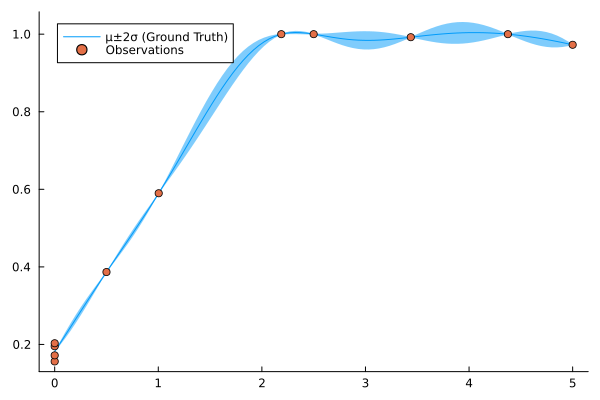

In [96]:
plot1D(sur_ei_high_fidelity; xmin=0., xmax=5.)

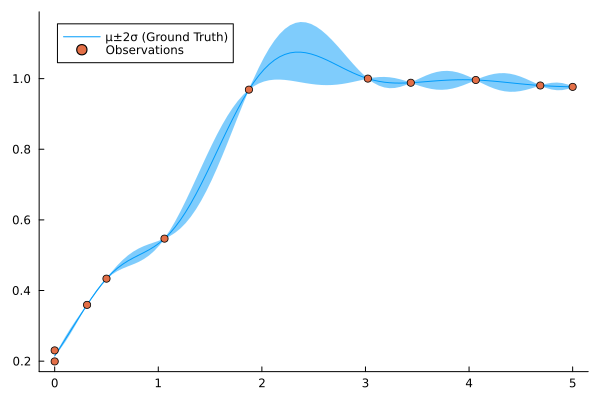

In [97]:
plot1D(sur_ei_low_fidelity; xmin=0., xmax=5.)